Using Colab cache for faster access to the 'legalclausedataset' dataset.
Path to dataset files: /kaggle/input/legalclausedataset
HARDWARE CHECK
Using device: CUDA
GPU: Tesla T4

Loading data...
Loading 50 CSV files (out of 395 total)
Loaded certain-definitions.csv: 200 clauses
Loaded proprietary_rights.csv: 200 clauses
Loaded limitation-of-liability.csv: 200 clauses
Loaded severability-of-provisions.csv: 200 clauses
Loaded other-agreements.csv: 200 clauses
Loaded representations.csv: 200 clauses
Loaded payment-terms.csv: 200 clauses
Loaded definitions.csv: 200 clauses
Loaded effectiveness.csv: 200 clauses
Loaded additional-documents.csv: 200 clauses
Loaded no-assignment.csv: 200 clauses
Loaded benefits.csv: 200 clauses
Loaded vesting.csv: 200 clauses
Loaded construction.csv: 200 clauses
Loaded time-of-the-essence.csv: 200 clauses
Loaded entire-agreement.csv: 200 clauses
Loaded execution.csv: 200 clauses
Loaded material-contracts.csv: 200 clauses
Loaded cooperation.csv: 200 clauses
Load

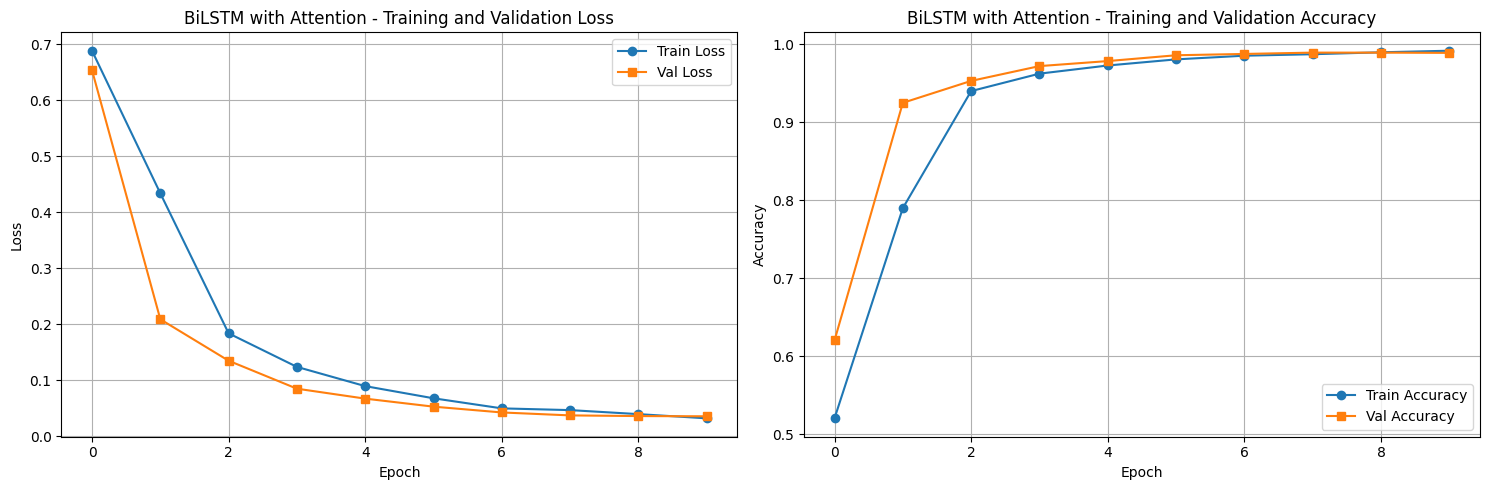

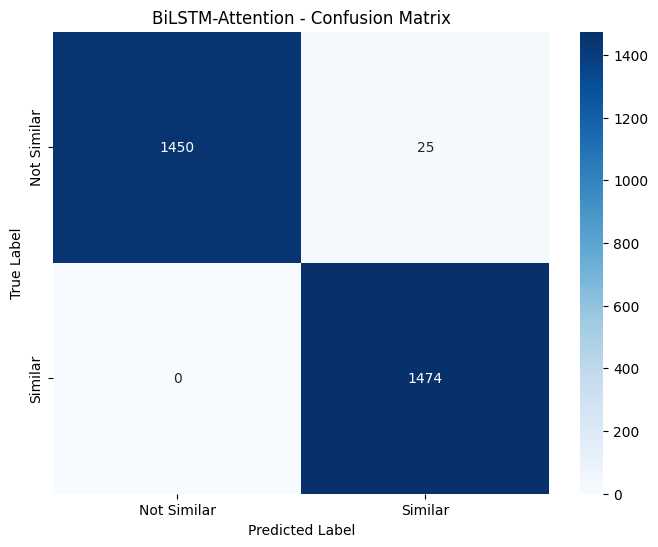


TRAINING MODEL 2: CNN Encoder
Training on cuda
Epoch 1/10
  Train Loss: 0.7000, Train Acc: 0.5004
  Val Loss: 0.6932, Val Acc: 0.5002
Epoch 2/10
  Train Loss: 0.6933, Train Acc: 0.5045
  Val Loss: 0.6925, Val Acc: 0.5205
Epoch 3/10
  Train Loss: 0.6928, Train Acc: 0.5096
  Val Loss: 0.6920, Val Acc: 0.5181
Epoch 4/10
  Train Loss: 0.6912, Train Acc: 0.5137
  Val Loss: 0.6914, Val Acc: 0.5205
Epoch 5/10
  Train Loss: 0.6882, Train Acc: 0.5220
  Val Loss: 0.6892, Val Acc: 0.5059
Epoch 6/10
  Train Loss: 0.6775, Train Acc: 0.5310
  Val Loss: 0.6654, Val Acc: 0.5700
Epoch 7/10
  Train Loss: 0.6528, Train Acc: 0.5789
  Val Loss: 0.6328, Val Acc: 0.6399
Epoch 8/10
  Train Loss: 0.6074, Train Acc: 0.6358
  Val Loss: 0.5623, Val Acc: 0.7053
Epoch 9/10
  Train Loss: 0.5655, Train Acc: 0.6778
  Val Loss: 0.5362, Val Acc: 0.7392
Epoch 10/10
  Train Loss: 0.5347, Train Acc: 0.7054
  Val Loss: 0.4879, Val Acc: 0.7684

EVALUATION METRICS
Accuracy:  0.7898
Precision: 0.7271
Recall:    0.9274
F1-Scor

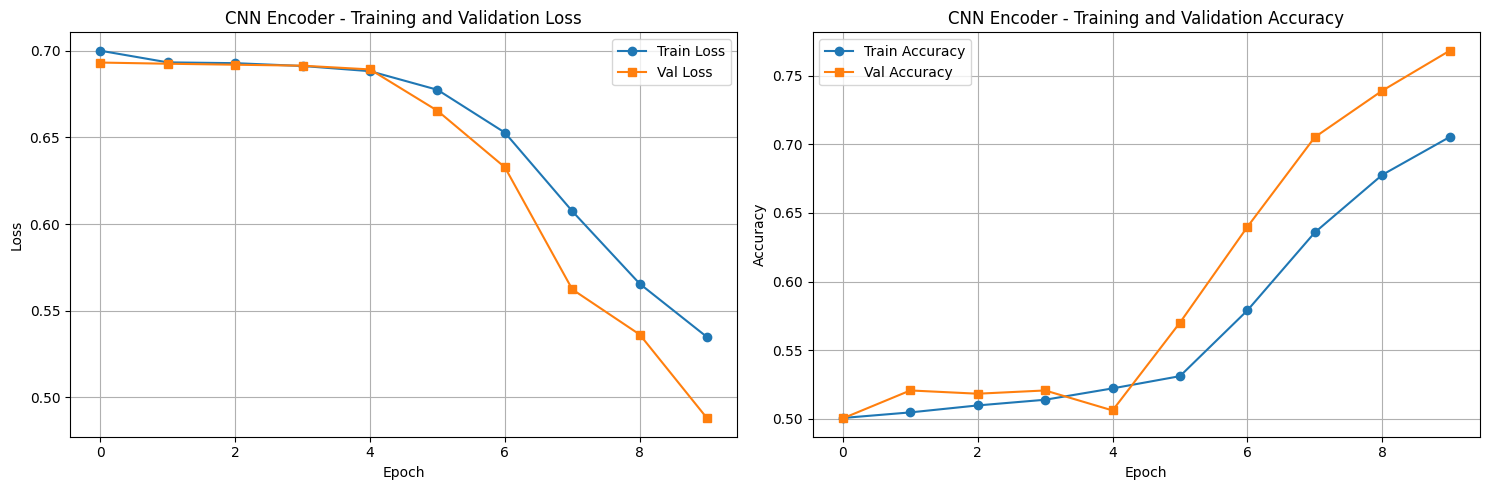

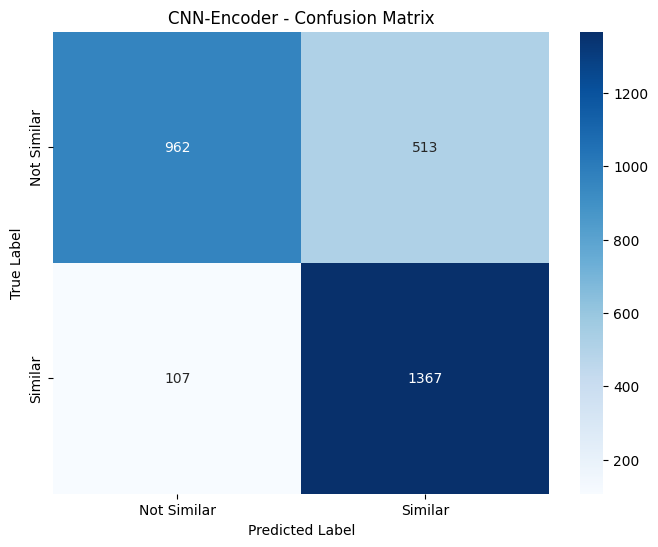


MODEL COMPARISON


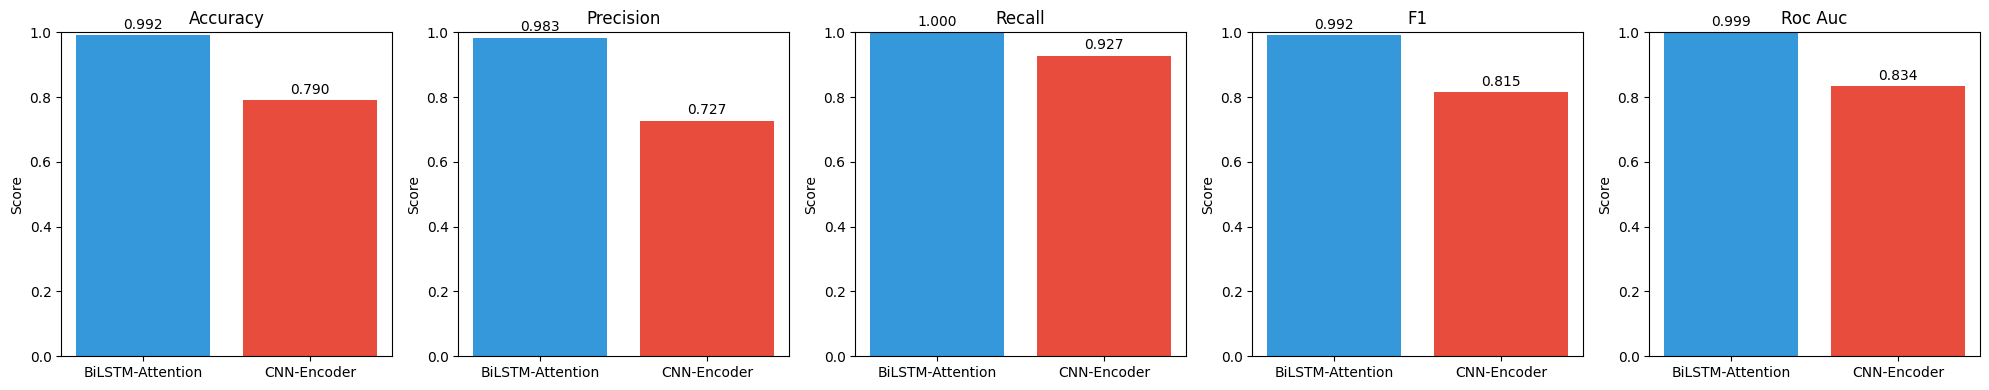


SAMPLE CORRECT PREDICTIONS

Clause 1: Parties in Interest. This Agreement shall be binding upon and shall inure to the benefit of the parties hereto and their respective heirs, executors, ...
Clause 2: Parties in Interest. All grants, covenants and agreements contained in this Amendment and Restatement shall bind and inure to the benefit of the parti...
True Label: 1, Predicted: 1
--------------------------------------------------------------------------------

Clause 1: Compliance. Merchant agrees to comply with all Debit Network rules, regulations, procedures, fees, assessments, penalties, and other membership duties...
Clause 2: Compliance. 18 A. COUNTY’s Health Care Agency (HCA) has established a Compliance Program for the purpose 19 of ensuring adherence to all rules and reg...
True Label: 1, Predicted: 1
--------------------------------------------------------------------------------

Clause 1: Bank Accounts. The bank accounts of the Partnership shall be maintained in such banki

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Download dataset
path = kagglehub.dataset_download("bahushruth/legalclausedataset")
print("Path to dataset files:", path)

# ==================== DATA LOADING AND PREPROCESSING ====================

class DataPreprocessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.vocab = {}
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}

    def load_data(self, max_files=50):  # REDUCED: Load only 50 files instead of all
        """Load CSV files from the dataset"""
        csv_files = [f for f in os.listdir(self.data_path) if f.endswith('.csv')][:max_files]
        print(f"Loading {len(csv_files)} CSV files (out of {len([f for f in os.listdir(self.data_path) if f.endswith('.csv')])} total)")

        all_data = []
        for csv_file in csv_files:
            try:
                df = pd.read_csv(os.path.join(self.data_path, csv_file))
                if 'clause_text' in df.columns and 'clause_type' in df.columns:
                    # Sample only 200 clauses per file
                    if len(df) > 200:
                        df = df.sample(200, random_state=42)
                    all_data.append(df[['clause_text', 'clause_type']])
                    print(f"Loaded {csv_file}: {len(df)} clauses")
            except Exception as e:
                print(f"Error loading {csv_file}: {e}")

        if all_data:
            combined_df = pd.concat(all_data, ignore_index=True)
            combined_df = combined_df.dropna()
            print(f"\nTotal clauses loaded: {len(combined_df)}")
            return combined_df
        return pd.DataFrame()

    def clean_text(self, text):
        """Clean and normalize text"""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        # Truncate long texts
        words = text.split()[:100]  # Max 100 words per clause
        return ' '.join(words)

    def build_vocab(self, texts, min_freq=3, max_vocab=10000):  # REDUCED: Smaller vocab
        """Build vocabulary from texts"""
        word_freq = {}
        for text in texts:
            words = text.split()
            for word in words:
                word_freq[word] = word_freq.get(word, 0) + 1

        # Sort by frequency and take top words
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

        idx = len(self.word2idx)
        for word, freq in sorted_words:
            if freq >= min_freq and idx < max_vocab:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)}")
        return self.word2idx

    def text_to_indices(self, text):
        """Convert text to list of indices"""
        words = text.split()
        return [self.word2idx.get(word, 1) for word in words]

# ==================== CREATE SIMILARITY PAIRS ====================

class PairGenerator:
    def __init__(self, df):
        self.df = df

    def create_pairs(self, max_pairs_per_type=200):  # REDUCED: Fewer pairs
        """Create positive and negative clause pairs"""
        pairs = []
        labels = []

        # Group by clause type
        grouped = self.df.groupby('clause_type')

        # Positive pairs (same type)
        for clause_type, group in grouped:
            clauses = group['clause_text'].values
            if len(clauses) < 2:
                continue

            n_positive = min(len(clauses) * 2, max_pairs_per_type)
            for _ in range(n_positive):
                idx1, idx2 = np.random.choice(len(clauses), 2, replace=False)
                pairs.append((clauses[idx1], clauses[idx2]))
                labels.append(1)

        # Negative pairs (different types)
        n_negative = len(labels)
        types = self.df['clause_type'].unique()

        for _ in range(n_negative):
            type1, type2 = np.random.choice(types, 2, replace=False)
            clause1 = self.df[self.df['clause_type'] == type1].sample(1)['clause_text'].values[0]
            clause2 = self.df[self.df['clause_type'] == type2].sample(1)['clause_text'].values[0]
            pairs.append((clause1, clause2))
            labels.append(0)

        print(f"Created {len(pairs)} pairs ({sum(labels)} positive, {len(labels)-sum(labels)} negative)")
        return pairs, labels

# ==================== PYTORCH DATASET ====================

class ClausePairDataset(Dataset):
    def __init__(self, pairs, labels, preprocessor):
        self.pairs = pairs
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        clause1, clause2 = self.pairs[idx]
        label = self.labels[idx]

        # Clean and convert to indices
        clause1_clean = self.preprocessor.clean_text(clause1)
        clause2_clean = self.preprocessor.clean_text(clause2)

        clause1_idx = self.preprocessor.text_to_indices(clause1_clean)
        clause2_idx = self.preprocessor.text_to_indices(clause2_clean)

        return (torch.LongTensor(clause1_idx),
                torch.LongTensor(clause2_idx),
                torch.FloatTensor([label]))

def collate_fn(batch):
    """Collate function for DataLoader"""
    clause1_list, clause2_list, labels = zip(*batch)

    clause1_padded = pad_sequence(clause1_list, batch_first=True, padding_value=0)
    clause2_padded = pad_sequence(clause2_list, batch_first=True, padding_value=0)
    labels = torch.cat(labels)

    return clause1_padded, clause2_padded, labels

# ==================== MODEL 1: BiLSTM WITH ATTENTION ====================

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context

class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, dropout=0.3):  # REDUCED dimensions
        super(BiLSTMAttention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1,  # REDUCED to 1 layer
                           bidirectional=True, batch_first=True, dropout=0)
        self.attention = AttentionLayer(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Classifier
        self.fc1 = nn.Linear(hidden_dim * 4, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def encode_clause(self, clause):
        embedded = self.embedding(clause)
        lstm_out, _ = self.lstm(embedded)
        context = self.attention(lstm_out)
        return context

    def forward(self, clause1, clause2):
        context1 = self.encode_clause(clause1)
        context2 = self.encode_clause(clause2)

        combined = torch.cat([context1, context2], dim=1)
        combined = self.dropout(combined)

        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = torch.sigmoid(self.fc2(x))

        return output.squeeze()

# ==================== MODEL 2: CNN-BASED ENCODER ====================

class CNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, num_filters=128, filter_sizes=[3, 4, 5], dropout=0.3):  # REDUCED dimensions
        super(CNNEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)

        total_filters = num_filters * len(filter_sizes)
        self.fc1 = nn.Linear(total_filters * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def encode_clause(self, clause):
        embedded = self.embedding(clause)
        embedded = embedded.permute(0, 2, 1)

        conv_outputs = []
        for conv in self.convs:
            conv_out = self.relu(conv(embedded))
            pooled = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(pooled)

        combined = torch.cat(conv_outputs, dim=1)
        return combined

    def forward(self, clause1, clause2):
        repr1 = self.encode_clause(clause1)
        repr2 = self.encode_clause(clause2)

        combined = torch.cat([repr1, repr2], dim=1)
        combined = self.dropout(combined)

        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = torch.sigmoid(self.fc2(x))

        return output.squeeze()

# ==================== TRAINING CLASS ====================

class ModelTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self, dataloader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for clause1, clause2, labels in dataloader:
            clause1, clause2, labels = clause1.to(self.device), clause2.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(clause1, clause2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        return total_loss / len(dataloader), correct / total

    def evaluate(self, dataloader, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for clause1, clause2, labels in dataloader:
                clause1, clause2, labels = clause1.to(self.device), clause2.to(self.device), labels.to(self.device)

                outputs = self.model(clause1, clause2)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())

        return total_loss / len(dataloader), correct / total, all_preds, all_labels, all_probs

    def train(self, train_loader, val_loader, epochs=10, lr=0.001):  # REDUCED to 10 epochs
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        print(f"Training on {self.device}")

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _, _ = self.evaluate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return self.train_losses, self.val_losses, self.train_accs, self.val_accs

# ==================== EVALUATION AND VISUALIZATION ====================

def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Comprehensive evaluation of model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for clause1, clause2, labels in test_loader:
            clause1, clause2, labels = clause1.to(device), clause2.to(device), labels.to(device)
            outputs = model(clause1, clause2)
            predicted = (outputs > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0

    print("\n" + "="*50)
    print("EVALUATION METRICS")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("="*50)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

def plot_training_history(train_losses, val_losses, train_accs, val_accs, model_name="Model"):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(val_accs, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} - Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, predictions, model_name="Model"):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Similar', 'Similar'],
                yticklabels=['Not Similar', 'Similar'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def compare_models(results_dict):
    """Compare multiple models"""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    model_names = list(results_dict.keys())

    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

    for idx, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in model_names]
        axes[idx].bar(model_names, values, color=['#3498db', '#e74c3c', '#2ecc71'][:len(model_names)])
        axes[idx].set_title(metric.replace('_', ' ').title())
        axes[idx].set_ylim([0, 1])
        axes[idx].set_ylabel('Score')
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

def show_sample_predictions(test_pairs, predictions, labels, n_samples=3):  # REDUCED samples
    """Show sample correct and incorrect predictions"""
    correct_idx = np.where(predictions == labels)[0]
    incorrect_idx = np.where(predictions != labels)[0]

    print("\n" + "="*80)
    print("SAMPLE CORRECT PREDICTIONS")
    print("="*80)
    for i in np.random.choice(correct_idx, min(n_samples, len(correct_idx)), replace=False):
        clause1, clause2 = test_pairs[i]
        print(f"\nClause 1: {clause1[:150]}...")
        print(f"Clause 2: {clause2[:150]}...")
        print(f"True Label: {int(labels[i])}, Predicted: {int(predictions[i])}")
        print("-"*80)

    if len(incorrect_idx) > 0:
        print("\n" + "="*80)
        print("SAMPLE INCORRECT PREDICTIONS")
        print("="*80)
        for i in np.random.choice(incorrect_idx, min(n_samples, len(incorrect_idx)), replace=False):
            clause1, clause2 = test_pairs[i]
            print(f"\nClause 1: {clause1[:150]}...")
            print(f"Clause 2: {clause2[:150]}...")
            print(f"True Label: {int(labels[i])}, Predicted: {int(predictions[i])}")
            print("-"*80)

# ==================== MAIN EXECUTION ====================

def main():
    # Check hardware
    print("="*50)
    print("HARDWARE CHECK")
    print("="*50)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device.upper()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("="*50 + "\n")

    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)

    # Load and preprocess data
    print("Loading data...")
    preprocessor = DataPreprocessor(path)
    df = preprocessor.load_data(max_files=50)  # Load only 50 files

    if df.empty:
        print("No data loaded. Please check the dataset path.")
        return

    # Clean texts
    print("\nCleaning texts...")
    df['clause_text_clean'] = df['clause_text'].apply(preprocessor.clean_text)

    # Build vocabulary
    print("\nBuilding vocabulary...")
    preprocessor.build_vocab(df['clause_text_clean'].values, max_vocab=10000)

    # Create pairs
    print("\nCreating clause pairs...")
    pair_gen = PairGenerator(df)
    pairs, labels = pair_gen.create_pairs(max_pairs_per_type=200)

    # Split data
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, test_size=0.3, random_state=42, stratify=labels
    )
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    print(f"\nData splits:")
    print(f"  Train: {len(train_pairs)} pairs")
    print(f"  Val: {len(val_pairs)} pairs")
    print(f"  Test: {len(test_pairs)} pairs")

    # Create datasets and dataloaders
    batch_size = 64  # INCREASED batch size
    train_dataset = ClausePairDataset(train_pairs, train_labels, preprocessor)
    val_dataset = ClausePairDataset(val_pairs, val_labels, preprocessor)
    test_dataset = ClausePairDataset(test_pairs, test_labels, preprocessor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    vocab_size = len(preprocessor.word2idx)

    results = {}

    # ==================== TRAIN MODEL 1: BiLSTM with Attention ====================
    print("\n" + "="*80)
    print("TRAINING MODEL 1: BiLSTM with Attention")
    print("="*80)

    model1 = BiLSTMAttention(vocab_size=vocab_size)
    trainer1 = ModelTrainer(model1, device)
    train_losses1, val_losses1, train_accs1, val_accs1 = trainer1.train(
        train_loader, val_loader, epochs=10, lr=0.001  # 10 epochs
    )

    # Evaluate Model 1
    results['BiLSTM-Attention'] = evaluate_model(model1, test_loader, device)
    plot_training_history(train_losses1, val_losses1, train_accs1, val_accs1, "BiLSTM with Attention")
    plot_confusion_matrix(results['BiLSTM-Attention']['labels'],
                         results['BiLSTM-Attention']['predictions'],
                         "BiLSTM-Attention")

    # ==================== TRAIN MODEL 2: CNN Encoder ====================
    print("\n" + "="*80)
    print("TRAINING MODEL 2: CNN Encoder")
    print("="*80)

    model2 = CNNEncoder(vocab_size=vocab_size)
    trainer2 = ModelTrainer(model2, device)
    train_losses2, val_losses2, train_accs2, val_accs2 = trainer2.train(
        train_loader, val_loader, epochs=10, lr=0.001  # 10 epochs
    )

    # Evaluate Model 2
    results['CNN-Encoder'] = evaluate_model(model2, test_loader, device)
    plot_training_history(train_losses2, val_losses2, train_accs2, val_accs2, "CNN Encoder")
    plot_confusion_matrix(results['CNN-Encoder']['labels'],
                         results['CNN-Encoder']['predictions'],
                         "CNN-Encoder")

    # ==================== COMPARE MODELS ====================
    print("\n" + "="*80)
    print("MODEL COMPARISON")
    print("="*80)
    compare_models(results)

    # Show sample predictions
    show_sample_predictions(test_pairs,
                          results['BiLSTM-Attention']['predictions'],
                          results['BiLSTM-Attention']['labels'])

    print("\n" + "="*80)
    print("TRAINING COMPLETE!")
    print("="*80)

    return results, preprocessor, model1, model2

# Run the main function
if __name__ == "__main__":
    results, preprocessor, model1, model2 = main()